In [1]:
import os
import time

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
from hamiltonian import Hamiltonian

from rgf import GreensFunction
from utils import smart_inverse
import numpy as np
import scipy.sparse as sp
import scipy.constants as spc
import matplotlib.pyplot as plt
import poisson 
import scipy.optimize._zeros_py as zero_scipy
ham = Hamiltonian("one_d_wire")
gf = GreensFunction(ham)


In [2]:
gf.compute_charge_density(use_rgf=False)

array([0.03215056, 0.03215056, 0.03215056, 0.03215056, 0.03215056,
       0.03215056, 0.03215056, 0.03215056, 0.03215056, 0.03215056,
       0.03215056, 0.03215056, 0.03215056, 0.03215056, 0.03215056,
       0.03215056, 0.03215056, 0.03215056, 0.03215056, 0.03215056])

In [3]:
gf.compute_charge_density(use_rgf=True)

array([0.03215056, 0.03215056, 0.03215056, 0.03215056, 0.03215056,
       0.03215056, 0.03215056, 0.03215056, 0.03215056, 0.03215056,
       0.03215056, 0.03215056, 0.03215056, 0.03215056, 0.03215056,
       0.03215056, 0.03215056, 0.03215056, 0.03215056, 0.03215056])

In [4]:
hbar = 1.06e-34
q = 1.6e-19
m = 0.25 * 9.1e-31
IE = (q**2) / (2 * np.pi * hbar)  # Conductance quantum
Ef = 0.1  # Fermi energy in eV
kT = 0.025  # Thermal energy in eV

# ===================================================================
# Inputs and Device Structure
# ===================================================================
a = 3e-10  # Lattice spacing in meters
t0 = (hbar**2) / (2 * m * (a**2) * q)  # Hopping parameter in eV

# Define device regions: Source, Channel, Drain

# NS = 15
# NC = 16
# ND = 15
# Np = NS + NC + ND  # Total number of points
NS=23
NC=4
ND=23
Np=NS+NC+ND
IE = ham.q**2 / (2 * np.pi * hbar)
ham.Ef = 0.1
ham.kbT_eV = 0.025


ham.N = Np
ham.o = 2 *t0
ham.t = 1 * t0
ham.set_voltage()

gf.lead_self_energy.self_energy("left", 0)
print(gf.lead_self_energy.self_energy("left", 0))
gf.enable_buttiker_probe(0.00025)


NV = 26
VV = np.linspace(0, 0.5, NV)
II = [None] * NV
for iV in range(NV):

    V = VV[iV]
    mu1 = ham.Ef + (V / 2)
    mu2 = ham.Ef - (V / 2)
    ham.mu1 = mu1
    ham.mu2 = mu2
    
    part1 = 0.5 * np.ones(NS)
    part2 = np.linspace(0.5, -0.5, NC)
    part3 = -0.5 * np.ones(ND)

    # Concatenate the parts and multiply by V
    U1 = V * np.concatenate((part1, part2, part3)) 
    # zeros_NS = np.zeros(NS)
    # barrier_part1 = 0.4 * np.ones(4)
    # zeros_channel = np.zeros(NC - 8)
    # barrier_part2 = 0.4 * np.ones(4)
    # zeros_ND = np.zeros(ND)
    #UB = np.concatenate([zeros_NS, barrier_part1, zeros_channel, barrier_part2, zeros_ND]) 
    UB=np.concatenate([np.zeros(NS), 0.0*np.ones(NC), np.zeros(ND)])
    ham.set_potential(U1+UB)

    NE = 101
    E = np.linspace(-0.2, 0.8, NE)
    zplus = 1j * 1e-12  # Infinitesimal for Green's function
    dE = E[1] - E[0]
    I = 0 
    TM = np.zeros(NE)  

    I = gf.compute_total_current(use_rgf=False)
    II[iV] = I


[[-1.71489529-9.25865028e-07j]]
Starting current calculations for 301 (E, ky) pairs...
Starting current calculations for 301 (E, ky) pairs...
Starting current calculations for 301 (E, ky) pairs...
Starting current calculations for 301 (E, ky) pairs...
Starting current calculations for 301 (E, ky) pairs...
Starting current calculations for 301 (E, ky) pairs...
Starting current calculations for 301 (E, ky) pairs...
Starting current calculations for 301 (E, ky) pairs...
Starting current calculations for 301 (E, ky) pairs...
Starting current calculations for 301 (E, ky) pairs...
Starting current calculations for 301 (E, ky) pairs...
Starting current calculations for 301 (E, ky) pairs...
Starting current calculations for 301 (E, ky) pairs...
Starting current calculations for 301 (E, ky) pairs...
Starting current calculations for 301 (E, ky) pairs...
Starting current calculations for 301 (E, ky) pairs...
Starting current calculations for 301 (E, ky) pairs...
Starting current calculations for

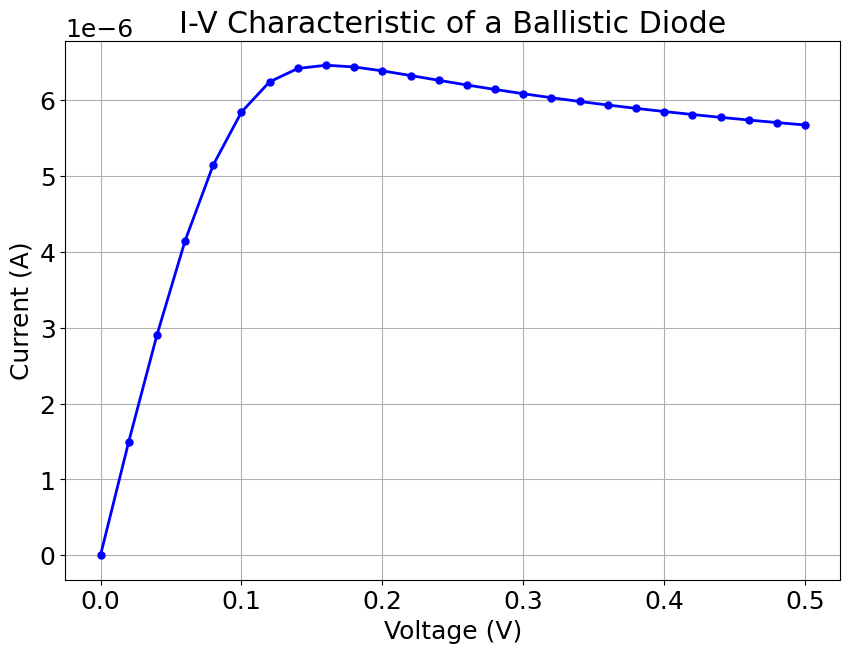

In [5]:
plt.figure(figsize=(10, 7))
plt.plot(VV, II, 'b-o', linewidth=2.0, markersize=5)

# --- Plotting settings ---
# You can uncomment and adapt other plots from the MATLAB script
# XX = a * 1e9 * np.arange(1, Np + 1)
# plt.plot(XX, U1 + UB, 'r--') # Plot potential profile

plt.rcParams.update({'font.size': 18})
plt.xlabel("Voltage (V)")
plt.ylabel("Current (A)")
plt.title("I-V Characteristic of a Ballistic Diode")

plt.grid(True)
plt.show()

In [4]:
def _sancho_rubio_surface_gf(E, H00, H01, S00=None, iter_max=100, TOL=1e-10):
    """
    Jiezi surface_gf algorithm translated to use numpy arrays
    """

    n = H00.shape[0]
    I = np.eye(n, dtype=complex)
    
    # Handle overlap matrix
    if S00 is None:
        S00 = I
        
    # Convert to dense if needed
    if hasattr(H00, 'toarray'):
        H00 = H00.toarray()
    if hasattr(H01, 'toarray'):
        H01 = H01.toarray()
    if hasattr(S00, 'toarray'):
        S00 = S00.toarray()
    
    iter_c = 0
    H10 = H01.conj().T
    alpha = H10.copy()
    beta = H10.conj().T  # H10.dagger()
    epsilon = H00.copy()
    epsilon_s = H00.copy()
    E = I * E
    
    while iter_c < iter_max:
        iter_c += 1
        
        # inv_term = (w - epsilon)^(-1)
        inv_term = np.linalg.solve(E - epsilon, I)
        
        # alpha_new = alpha * inv_term * alpha
        alpha_new = alpha @ inv_term @ alpha
        
        # beta_new = beta * inv_term * beta  
        beta_new = beta @ inv_term @ beta
        
        # epsilon_new = epsilon + alpha*inv_term*beta + beta*inv_term*alpha
        epsilon_new = epsilon + alpha @ inv_term @ beta + beta @ inv_term @ alpha
        
        # epsilon_s_new = epsilon_s + alpha*inv_term*beta
        epsilon_s_new = epsilon_s + alpha @ inv_term @ beta
        
        # Check convergence using Frobenius norm
        convergence_check = np.linalg.norm(alpha_new, ord='fro')
        
        if convergence_check < TOL:
            G00 = np.linalg.solve(E - epsilon_s_new, I)
            GBB = np.linalg.solve(E - epsilon_new, I)
            break
        else:
            alpha = alpha_new.copy()
            beta = beta_new.copy() 
            epsilon = epsilon_new.copy()
            epsilon_s = epsilon_s_new.copy()
    

    return G00

H00, H01, H10= ham.get_H00_H01_H10()
print(H00.toarray())
_sancho_rubio_surface_gf(-.2+ 1e-12j, H00, H01) *t0**2




[[3.42979243]]


array([[-1.22077565-1.02738041e-12j]])

In [10]:
gf.lead_self_energy.self_energy(side="left", E=-.2)

array([[-1.22077565-1.02738041e-12j]])

In [7]:
zplus = 1e-12j
ck_s = 1 - (-.2 + zplus) / (2 * t0)

ka_s = np.arccos(ck_s)
print(-t0 * np.exp(1j * ka_s))


-np.exp(1j * ka_s) / t0 

(-1.2207756522330102-1.027380408078085e-12j)


np.complex128(-0.41510711312401144-3.493458560525595e-13j)

In [18]:
ck_s = 1 - ((-.2 + zplus) / (2 * t0))
print(ck_s)
ka_s = np.arccos(ck_s)
sig1 = np.zeros((Np, Np), dtype=complex)
sig1[0, 0] = -t0 * np.exp(1j * ka_s)
print(sig1[0, 0])

print(t0)


(1.058312566749733-2.9156283374866493e-13j)
(-1.2207756522330102-1.027380408078085e-12j)
1.7148962148962152


Voltage = 0.000 V, Current = 0.000e+00 A
Voltage = 0.020 V, Current = 8.044e-08 A
Voltage = 0.040 V, Current = 1.520e-07 A
[[ 3.45979243 -1.71489621  0.         ...  0.          0.
   0.        ]
 [-1.71489621  3.45979243 -1.71489621 ...  0.          0.
   0.        ]
 [ 0.         -1.71489621  3.45979243 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  3.39979243 -1.71489621
   0.        ]
 [ 0.          0.          0.         ... -1.71489621  3.39979243
  -1.71489621]
 [ 0.          0.          0.         ...  0.         -1.71489621
   3.39979243]]
[[-8.41568909e-01-6.68125906e-12j -5.99076267e-01-8.39064472e-12j
  -4.26450974e-01-1.07292537e-11j ... -1.38647082e-07-3.03651455e-11j
  -1.04289625e-07-2.28405070e-11j -7.84461215e-08-1.71805124e-11j]
 [-5.99076267e-01-8.39064472e-12j -8.41558087e-01-1.10785995e-11j
  -5.99061063e-01-1.45678634e-11j ... -1.94765809e-07-4.26557270e-11j
  -1.46501843e-07-3.20854194e-11j -1.10197936e-07-2.41344882e-11j]
 [-

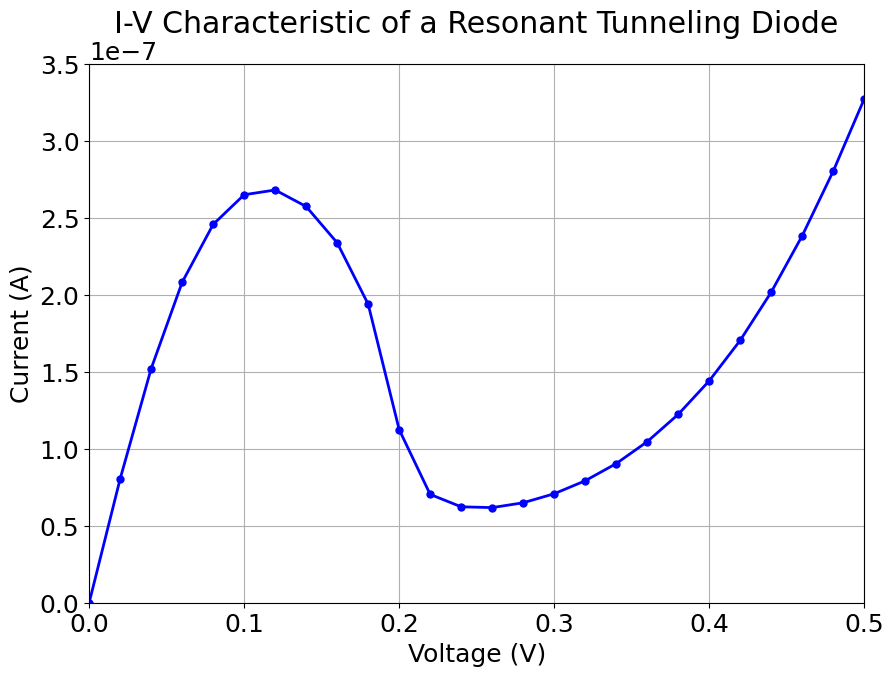

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# ===================================================================
# Constants (all MKS, except energy which is in eV)
# ===================================================================
hbar = 1.06e-34
q = 1.6e-19
m = 0.25 * 9.1e-31
IE = (q**2) / (2 * np.pi * hbar)  # Conductance quantum
Ef = 0.1  # Fermi energy in eV
kT = 0.025  # Thermal energy in eV

# ===================================================================
# Inputs and Device Structure
# ===================================================================
a = 3e-10  # Lattice spacing in meters
t0 = (hbar**2) / (2 * m * (a**2) * q)  # Hopping parameter in eV

# Define device regions: Source, Channel, Drain
NS = 15
NC = 16
ND = 15
Np = NS + NC + ND  # Total number of points

# Potential Barrier UB(z)
# This section defines the potential barrier profile UB.
# The active configuration is for a Resonant Tunneling (RT) barrier.
zeros_NS = np.zeros(NS)
barrier_part1 = 0.4 * np.ones(4)
zeros_channel = np.zeros(NC - 8)
barrier_part2 = 0.4 * np.ones(4)
zeros_ND = np.zeros(ND)
UB = np.concatenate([zeros_NS, barrier_part1, zeros_channel, barrier_part2, zeros_ND])

# ===================================================================
# Hamiltonian Matrix (Tight-Binding Model)
# ===================================================================
# Kinetic energy part (tri-diagonal matrix)
T_kinetic = (2 * t0 * np.eye(Np)) - (t0 * np.diag(np.ones(Np - 1), 1)) - (t0 * np.diag(np.ones(Np - 1), -1))

# Add the potential barrier UB to the diagonal
H0 = T_kinetic + np.diag(UB)  # Time-independent Hamiltonian

# ===================================================================
# Main Bias Loop
# ===================================================================
NV = 26  # Number of voltage points
VV = np.linspace(0, 0.5, NV)  # Voltage vector
II = np.zeros(NV)  # Array to store current for each voltage

# Energy grid for Green's function method
NE = 101
E = np.linspace(-0.2, 0.8, NE)
zplus = 1j * 1e-12  # Infinitesimal for Green's function
dE = E[1] - E[0]

for iV in range(NV):
    V = VV[iV]
    mu1 = Ef + (V / 2)  # Chemical potential of the source
    mu2 = Ef - (V / 2)  # Chemical potential of the drain

    # Applied potential profile U1 (linearly drops across the channel)
    U1_source = 0.5 * np.ones(NS)
    U1_channel = np.linspace(0.5, -0.5, NC)
    U1_drain = -0.5 * np.ones(ND)
    U1 = V * np.concatenate([U1_source, U1_channel, U1_drain])

    # Fermi-Dirac distribution functions for source and drain
    f1 = 1 / (1 + np.exp((E - mu1) / kT))
    f2 = 1 / (1 + np.exp((E - mu2) / kT))

    I = 0  # Initialize current for this bias
    TM = np.zeros(NE)  # To store transmission values for each energy point

    # ===============================================================
    # Energy Loop (Calculate Transmission T(E))
    # ===============================================================
    for k in range(NE):
        # Self-energy of the source contact (sig1) and its broadening (gam1)
        ck_s = 1 - ((E[k] + zplus - U1[0] - UB[0]) / (2 * t0))
        ka_s = np.arccos(ck_s)
        sig1 = np.zeros((Np, Np), dtype=complex)
        sig1[0, 0] = -t0 * np.exp(1j * ka_s)
        gam1 = 1j * (sig1 - sig1.conj().T)  # Corrected formula

        # Self-energy of the drain contact (sig2) and its broadening (gam2)
        ck_d = 1 - ((E[k] + zplus - U1[-1] - UB[-1]) / (2 * t0))
        ka_d = np.arccos(ck_d)
        sig2 = np.zeros((Np, Np), dtype=complex)
        sig2[Np - 1, Np - 1] = -t0 * np.exp(1j * ka_d)
        gam2 = 1j * (sig2 - sig2.conj().T)  # Corrected formula
        
        # Büttiker probe for incoherent scattering (optional)
        sig3 = np.zeros((Np, Np), dtype=complex)
        probe_strength = 0.00025 # eV
        sig3[Np // 2, Np // 2] = -1j * probe_strength
        gam3 = 1j * (sig3 - sig3.conj().T)  # Corrected formula *

        # Green's function G(E)
        E_mat = (E[k] + zplus) * np.eye(Np)
        H_total = H0 + np.diag(U1)
        Sigma = sig1 + sig2 + sig3
        G = np.linalg.inv(E_mat - H_total - Sigma)
        G_dagger = G.conj().T

        # Calculate transmission probabilities using the Fisher-Lee relation
        T12 = np.real(np.trace(gam1 @ G @ gam2 @ G_dagger))
        T13 = np.real(np.trace(gam1 @ G @ gam3 @ G_dagger))
        T23 = np.real(np.trace(gam2 @ G @ gam3 @ G_dagger))
        
        
        if k == 3 and iV == 3:

            print(H_total)
            print(G)

        # Total transmission with the Büttiker probe
        # The probe removes electrons, so we account for where they go
        if (T12 + T23) > 1e-12: # Avoid division by zero
            TM[k] = T12 + (T13 * T23 / (T12 + T23))
        else:
            TM[k] = T12

        # Landauer-Büttiker formula for current
        I += (dE * IE * TM[k] * (f1[k] - f2[k]))

    II[iV] = I
    print(f"Voltage = {V:.3f} V, Current = {I:.3e} A")

# ===================================================================
# Plotting
# ===================================================================
plt.figure(figsize=(10, 7))
plt.plot(VV, II, 'b-o', linewidth=2.0, markersize=5)

# --- Plotting settings ---
# You can uncomment and adapt other plots from the MATLAB script
# XX = a * 1e9 * np.arange(1, Np + 1)
# plt.plot(XX, U1 + UB, 'r--') # Plot potential profile

plt.rcParams.update({'font.size': 18})
plt.xlabel("Voltage (V)")
plt.ylabel("Current (A)")
plt.title("I-V Characteristic of a Resonant Tunneling Diode")
plt.xlim(0, 0.5)
plt.ylim(0, 3.5e-7)
plt.grid(True)
plt.show()

In [ ]:
ck_s = 1 - ((0 + zplus - 0 - 0.5) / (2 * t0))
ka_s = np.arccos(ck_s)
sig1 = np.zeros((Np, Np), dtype=complex)
sig1[0, 0] = -t0 * np.exp(1j * ka_s)
gam1 = 1j * (sig1 - sig1.conj().T)  # Corrected formula

# Self-energy of the drain contact (sig2) and its broadening (gam2)
ck_d = 1 - ((E[k] + zplus - U1[-1] - UB[-1]) / (2 * t0))
ka_d = np.arccos(ck_d)
sig2 = np.zeros((Np, Np), dtype=complex)
sig2[Np - 1, Np - 1] = -t0 * np.exp(1j * ka_d)
gam2 = 1j * (sig2 - sig2.conj().T)  # Corrected formula

# Büttiker probe for incoherent scattering (optional)
sig3 = np.zeros((Np, Np), dtype=complex)
probe_strength = 0.00025 # eV
sig3[Np // 2, Np // 2] = -1j * probe_strength
gam3 = 1j * (sig3 - sig3.conj().T)  # Corrected formula *

# Green's function G(E)
E_mat = (E[k] + zplus) * np.eye(Np)
H_total = H0 + np.diag(U1)
Sigma = sig1 + sig2 + sig3
G = np.linalg.inv(E_mat - H_total - Sigma)

In [4]:
gf.lead_self_energy.self_energy("left", 0.5)


array([[2.97419091e-61-5.94838182e-73j]])

In [ ]:
ham = Hamiltonian("one_d_wire")
gf = GreensFunction(ham)

n_negf = gf.compute_charge_density()

In [ ]:
n_fermi = gf.get_n(np.zeros(ham.N), Efn=np.ones(ham.N)*.38, Ec = -2)

In [ ]:
LDOS_matrix = gf.build_ldos_matrix()

In [ ]:
ham = Hamiltonian("one_d_wire")
gf = GreensFunction(ham)


energy = np.linspace(-5,5, 300)
dos = gf.calculate_DOS()


plt.plot(energy, dos)
plt.ylabel('DOS')
plt.xlabel('Energy')
plt.title('Energy vs DOS')

plt.show()

In [2]:
from utils import chandrupatla
ham = Hamiltonian("one_d_wire")

gf = GreensFunction(ham)

n_negf = gf.compute_charge_density()
def func(x, V):
    return gf.get_n(V,x, -2)- n_negf
roots_array = chandrupatla(func, np.ones(ham.N)*-10, np.ones(ham.N)*10, verbose=False, args=(np.zeros(ham.N),))

Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.


In [3]:
roots_array

array([-1.9894863, -1.9894863, -1.9894863, -1.9894863, -1.9894863,
       -1.9894863, -1.9894863, -1.9894863, -1.9894863, -1.9894863,
       -1.9894863, -1.9894863, -1.9894863, -1.9894863, -1.9894863,
       -1.9894863, -1.9894863, -1.9894863, -1.9894863, -1.9894863])

In [5]:
roots_array

def func(x, V):
    return gf.get_n(V,x, -2)- n_negf

func(roots_array, np.zeros(ham.N))

Running in parallel mode with 32 processes.


array([-7.42176459e-10, -7.42180768e-10, -7.42183232e-10, -7.42185764e-10,
       -7.42188241e-10, -7.42189692e-10, -7.42191850e-10, -7.42192113e-10,
       -7.42193418e-10, -7.42193723e-10, -7.42193709e-10, -7.42193390e-10,
       -7.42192086e-10, -7.42191801e-10, -7.42189650e-10, -7.42188172e-10,
       -7.42185723e-10, -7.42183197e-10, -7.42180706e-10, -7.42176424e-10])

Starting non-linear Poisson solver...
Running in parallel mode with 32 processes.
Iteration 1: Update norm = 7.3580e-03
Running in parallel mode with 32 processes.
Iteration 2: Update norm = 2.7147e-16

Converged after 2 iterations.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel mode with 32 processes.
Running in parallel

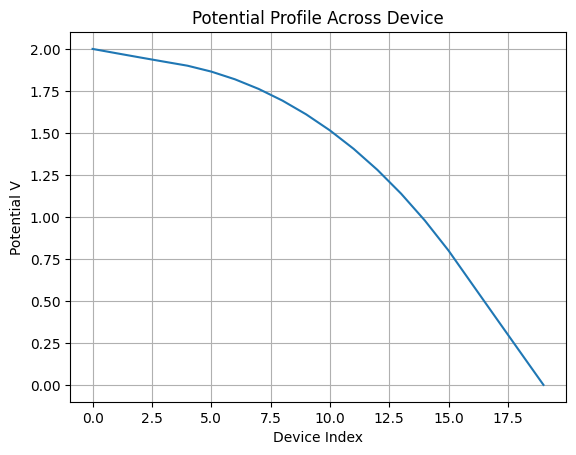

In [1]:
import os
import time

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
from hamiltonian import Hamiltonian
import matplotlib.pyplot as plt
import poisson 
from rgf import GreensFunction
import numpy as np
ham = Hamiltonian("one_d_wire")
ham.o = 0
ham.t = 1
gf = GreensFunction(ham)
ham.clear_potential()
ham.set_voltage(2, 0, 3)
VOLD, charge_density = poisson.solve_poisson_nonlinear(ham,gf, np.zeros(ham.N))
err = 1
while (err > 1e-4):
    gf.clear_ldos_cache()
    ham.set_potential(VOLD)
    Efn = gf.fermi_energy(VOLD)
    V, charge_density = poisson.solve_poisson_nonlinear(ham,gf, Efn )
    err = np.max(np.abs(V - VOLD))
    VOLD = V

import matplotlib.pyplot as plt

plt.plot(np.arange(len(V)), V)
plt.xlabel('Device Index')
plt.ylabel('Potential V')
plt.title('Potential Profile Across Device')
plt.grid(True)
plt.show()

In [2]:
gf.compute_total_current()

Starting current calculations for 300 (E, ky) pairs...


np.float64(5.00534796995833e-05)

In [ ]:
ham.get_potential(True)

In [ ]:
gf.get_n(np.zeros(ham.N), np.zeros(ham.N), -2)
gf.diff_rho_poisson(V = np.zeros(ham.N), Efn = np.zeros(ham.N), Ec= -2)

In [ ]:
print(ham.one_d_doping)

In [ ]:
X = ham.create_hamiltonian(False)

In [ ]:
energy = np.linspace(-5,5, 300)
dos = gf.calculate_DOS()


plt.plot(energy, dos)
plt.ylabel('DOS')
plt.xlabel('Energy')
plt.title('Energy vs DOS')

plt.show()

In [ ]:
energies = np.linspace(-2, 2, 100)
transmission = []
for E in energies:
    transmission.append(gf.compute_transmission(E=E))

plt.plot(energies, transmission)
plt.xlabel('Energy')
plt.ylabel('Transmission')
plt.title('Transmission vs Energy for QPC')
plt.show()

In [ ]:
# Sweep Fermi energy and plot transmission for QPC
ham = Hamiltonian("qpc")

ham.W = 10
ham.L = 30
ham.t = 1.0
ham.o = 0.0
ham.Vg = .1  # Moderate barrier

gf = GreensFunction(ham)

energies = np.linspace(-2, 2, 100)
transmission = []
for E in energies:
    transmission.append(gf.compute_transmission(E=E))

plt.plot(energies, transmission)
plt.xlabel('Energy')
plt.ylabel('Transmission')
plt.title('Transmission vs Energy for QPC')
plt.show()

In [ ]:
import os
import time

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
from hamiltonian import Hamiltonian
from rgf import GreensFunction
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
energy = np.linspace(-5,5, 400)

ham = Hamiltonian("armchair", periodic=False)
ham.mu1 = 0
ham.mu2 = 0
ham.Nx = 50
ham.Ef = 0
#ham.set_params(10, 3)

gf = GreensFunction(ham, energy_grid=energy)




dos = gf.calculate_DOS()
plt.plot(energy, dos)
plt.ylabel('DOS')
plt.xlabel('Energy')
plt.title('Energy vs DOS')

plt.show()



In [ ]:


# --- Plotting Code ---
structure = ham.unit_cell.structure

# Extract x and y coordinates from the list of Atom objects
x_coords = [atom.x for atom in structure]
y_coords = [atom.y for atom in structure]

# Create the plot
plt.figure(figsize=(8, 12))
plt.scatter(x_coords, y_coords, s=150, edgecolors='black', facecolors='skyblue', zorder=5)

# Add text labels to identify each atom's index in the list
for i, (x, y) in enumerate(zip(x_coords, y_coords)):
    plt.text(x + 0.05, y + 0.05, str(i), fontsize=9, ha='left', va='bottom', zorder=10)

# Formatting the plot for clarity
plt.title("Plot of Generated Atom Coordinates", fontsize=16)
plt.xlabel("X coordinate", fontsize=12)
plt.ylabel("Y coordinate", fontsize=12)
plt.axis('equal')  # This is CRUCIAL for correctly visualizing geometric structures

plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
import os
import time

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
from hamiltonian import Hamiltonian
from rgf import GreensFunction
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt


ham = Hamiltonian("armchair", True)
energy = np.linspace(-5,5, 200)
ham.reset_voltages()
ham.set_params(10, 3)

gf = GreensFunction(ham, energy_grid=energy)


H00, H01, H10 = ham.get_H00_H01_H10()
X = gf.lead_self_energy.self_energy("left", -2.45819398)
# energy = np.linspace(-5,5, 300)
dos = gf.calculate_DOS(use_rgf=False)


In [ ]:
ham = Hamiltonian("armchair", True)
ham.Nx = 2
H0, T0 = ham._create_armchair_hamiltonian_periodic()

T0.toarray()

In [ ]:

plt.plot(energy, dos)
plt.ylabel('DOS')
plt.xlabel('Energy')
plt.title('Energy vs DOS')

plt.show()


transmission = []
for E in energy:
    transmission.append(gf.compute_transmission(E=E))

plt.plot(energy, transmission)
plt.xlabel('Energy')
plt.ylabel('Transmission')
plt.title('Transmission vs Energy for QPC')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def run_transport_simulation():
    """
    Translates and runs a MATLAB script for calculating quantum transport
    properties using the Non-Equilibrium Green's Function (NEGF) method.
    """
    # --- Constants (all MKS, except energy which is in eV) ---
    hbar = 1.0545718e-34  # Corrected hbar value
    q = 1.60217662e-19
    m0 = 9.10938356e-31
    m_eff = 0.25 * m0  # Effective mass
    
    # This constant combines q^2 / (2*pi*hbar)
    # The original MATLAB code had a typo IE=(q*q)/(2*pi*hbar) which is G0/pi
    # The quantum of conductance is G0 = 2*q^2/h = q^2/(pi*hbar)
    IE = q**2 / (np.pi * hbar) 

    Ef = 0.1  # Fermi energy in eV
    kT = 0.025 # Thermal energy in eV

    # --- Inputs ---
    a = 3e-10  # Lattice spacing in meters
    # Hopping parameter in eV
    t0 = 1#hbar**2 / (2 * m_eff * a**2 * q) 

    # Device structure: Number of sites in Source, Channel, Drain
    # This corresponds to the Resonant Tunneling (RT) barrier case in the MATLAB script
    NS = 15
    NC = 16
    ND = 15
    Np = NS + NC + ND # Total number of points

    # --- Hamiltonian Matrix ---
    # Define the potential barrier UB
    # This setup creates two small barriers, simulating a resonant tunneling diode
    UB = np.zeros(Np)
    UB[NS : NS+4] = 0.4 * 0  # First barrier
    # The middle part from NS+4 to NS+NC-4 is zero
    UB[NS+NC-4 : NS+NC] = 0.4 * 0# Second barrier
    
    # Create the tight-binding Hamiltonian matrix T
    # Main diagonal
    main_diag = 2 * t0 * np.ones(Np)
    # Off-diagonals for nearest-neighbor hopping
    off_diag = -t0 * np.ones(Np - 1)
    
    T = np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(off_diag, k=-1)
    print(T)
    # Add the potential barrier to the Hamiltonian
    T = T + np.diag(UB)

    # --- Bias ---
    V = 0.0  # Applied bias in Volts
    mu1 = Ef + (V / 2)  # Chemical potential of the source
    mu2 = Ef - (V / 2)  # Chemical potential of the drain

    # Applied potential profile U1 due to bias
    # It drops linearly across the channel region
    U1 = np.concatenate([
        (V / 2) * np.ones(NS),
        np.linspace(V / 2, -V / 2, NC),
        (-V / 2) * np.ones(ND)
    ])

    # --- Energy Grid for Green’s function method ---
    NE = 501  # Number of energy points
    E = np.linspace(-0.2, 0.8, NE)
    dE = E[1] - E[0]
    zplus = 1j * 1e-12  # Small imaginary part for Green's functions

    # Fermi-Dirac distribution functions for source and drain
    f1 = 1 / (1 + np.exp((E - mu1) / kT))
    f2 = 1 / (1 + np.exp((E - mu2) / kT))

    # --- Main Loop for Transmission and Current Calculation ---
    I = 0.0  # Initialize current
    TM = np.zeros(NE) # Array to store transmission values

    print("Starting NEGF calculation...")
    for k in range(NE):
        Ek = E[k]
        
        # --- Self-Energies (sig1, sig2) ---
        # Self-energy for the source contact (left lead)
        # It's a non-zero matrix element only at the (0,0) position
        ck1 = 1 - (Ek + zplus - U1[0] - UB[0]) / (2 * t0)
        # Ensure the argument for arccos is within the valid range [-1, 1]
        # to avoid NaN results from small numerical errors
        if (Ek==.2):
            print(ck1)
        ck1 = np.clip(ck1, -1, 1) 
        ka1 = np.arccos(ck1)
        
        sig1 = np.zeros((Np, Np), dtype=complex)
        sig1[0, 0] = -t0 * np.exp(1j * ka1)
        if (Ek==.2):
            print(ck1)
            print(sig1[0,0])

        # Self-energy for the drain contact (right lead)
        # It's a non-zero matrix element only at the (Np-1, Np-1) position
        ck2 = 1 - (Ek + zplus - U1[-1] - UB[-1]) / (2 * t0)
        ck2 = np.clip(ck2, -1, 1)
        ka2 = np.arccos(ck2)

        sig2 = np.zeros((Np, Np), dtype=complex)
        sig2[Np - 1, Np - 1] = -t0 * np.exp(1j * ka2)
        
        
        # --- Broadening Matrices (gam1, gam2) ---
        gam1 = 1j * (sig1 - sig1.conj().T)
        gam2 = 1j * (sig2 - sig2.conj().T)
       
            

        # --- Green's Function (G) ---
        # G = inv( (E+iδ)I - H - Σ1 - Σ2 )
        # H is the device Hamiltonian (T + diag(U1))
        # Σ are the self-energies
        mat_to_invert = ((Ek + zplus) * np.eye(Np)) - T - np.diag(U1) - sig1 - sig2
        G = np.linalg.inv(mat_to_invert)

        # --- Transmission (TM) ---
        # TM(E) = Tr(Γ1 * G * Γ2 * G†)
        # G.conj().T is the conjugate transpose (dagger) of G
        TM[k] = np.real(np.trace(gam1 @ G @ gam2 @ G.conj().T))
        if (Ek == 0):
            print(np.real(np.trace(gam1 @ G @ gam2 @ G.conj().T)))
        
        # --- Current Calculation (Landauer-Büttiker formula) ---
        I += (dE * IE * TM[k] * (f1[k] - f2[k]))

    print(f"Calculation finished.")
    print(f"Total Current I = {I * 1e6:.4f} uA")

    # --- Plotting Results ---
    plt.figure(figsize=(12, 6))

    # Plot Transmission vs. Energy
    plt.subplot(1, 2, 1)
    plt.plot(E, TM, 'b', linewidth=2)
    plt.xlabel('Energy (eV)')
    plt.ylabel('Transmission T(E)')
    plt.title(f'Transmission Spectrum at V = {V} V')
    plt.grid(True)
    
    # Plot Potential Profile
    plt.subplot(1, 2, 2)
    sites = np.arange(Np) * a * 1e9 # Site position in nm
    plt.plot(sites, UB + U1, 'r-', label='Total Potential (U_B + U_1)', linewidth=2)
    plt.plot(sites, U1, 'g--', label='Applied Potential (U_1)', linewidth=1.5)
    plt.xlabel('Position (nm)')
    plt.ylabel('Potential (eV)')
    plt.title('Device Potential Profile')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# --- Run the simulation ---
if __name__ == '__main__':
    run_transport_simulation()



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Data Preparation ---
# I've extracted the voltage and current data you provided for each device.

# 1. Ballistic Device Data
v_ballistic = np.array([0.000, 0.020, 0.040, 0.060, 0.080, 0.100, 0.120, 0.140, 0.160, 0.180, 0.200, 0.220, 0.240, 0.260, 0.280, 0.300, 0.320, 0.340, 0.360, 0.380, 0.400, 0.420, 0.440, 0.460, 0.480, 0.500])
i_ballistic = np.array([0.0000, 0.4336, 0.7167, 0.8001, 0.8389, 0.8840, 0.8965, 0.8771, 0.8654, 0.8625, 0.8537, 0.8431, 0.8386, 0.8326, 0.8159, 0.7984, 0.7952, 0.8018, 0.8006, 0.7798, 0.7542, 0.7473, 0.7582, 0.7696, 0.7614, 0.7310])

# 2. Tunneling Device Data
v_tunneling = np.array([0.000, 0.020, 0.040, 0.060, 0.080, 0.100, 0.120, 0.140, 0.160, 0.180, 0.200, 0.220, 0.240, 0.260, 0.280, 0.300, 0.320, 0.340, 0.360, 0.380, 0.400, 0.420, 0.440, 0.460, 0.480, 0.500])
i_tunneling = np.array([0.0000, 0.0218, 0.0418, 0.0599, 0.0742, 0.0816, 0.0827, 0.0832, 0.0873, 0.0960, 0.1092, 0.1260, 0.1455, 0.1637, 0.1802, 0.1931, 0.2023, 0.2094, 0.2170, 0.2273, 0.2415, 0.2604, 0.2839, 0.3115, 0.3420, 0.3733])

# 3. Resonant Tunneling Device Data
v_resonant = np.array([0.000, 0.020, 0.040, 0.060, 0.080, 0.100, 0.120, 0.140, 0.160, 0.180, 0.200, 0.220, 0.240, 0.260, 0.280, 0.300, 0.320, 0.340, 0.360, 0.380, 0.400, 0.420, 0.440, 0.460, 0.480, 0.500])
i_resonant = np.array([0.0000, 0.0018, 0.0039, 0.0480, 0.0105, 0.0148, 0.0214, 0.0306, 0.0422, 0.0552, 0.0689, 0.0831, 0.0983, 0.1142, 0.1292, 0.1381, 0.1274, 0.0814, 0.0461, 0.0317, 0.0263, 0.0249, 0.0257, 0.0284, 0.0314, 0.0328])


# --- Plotting Setup ---
# We will create a figure with 3 subplots, one for each device.
# Using a nice style for the plots.
plt.style.use('seaborn-v0_8-whitegrid')
fig, axs = plt.subplots(3, 1, figsize=(8, 18)) # 3 rows, 1 column

# --- Plot 1: Ballistic Device ---
axs[0].plot(v_ballistic, i_ballistic, marker='o', linestyle='-', color='b', markersize=4)
axs[0].set_title('I-V Characteristics: Ballistic Device', fontsize=14)
axs[0].set_xlabel('Voltage (V)', fontsize=12)
axs[0].set_ylabel('Current (μA)', fontsize=12)
axs[0].set_xlim(0, 0.5)
axs[0].set_ylim(0, max(i_ballistic) * 1.1) # Add 10% padding to y-axis

# --- Plot 2: Tunneling Device ---
axs[1].plot(v_tunneling, i_tunneling, marker='s', linestyle='-', color='g', markersize=4)
axs[1].set_title('I-V Characteristics: Tunneling Device', fontsize=14)
axs[1].set_xlabel('Voltage (V)', fontsize=12)
axs[1].set_ylabel('Current (μA)', fontsize=12)
axs[1].set_xlim(0, 0.5)
axs[1].set_ylim(0, max(i_tunneling) * 1.1)

# --- Plot 3: Resonant Tunneling Device ---
axs[2].plot(v_resonant, i_resonant, marker='^', linestyle='-', color='r', markersize=4)
axs[2].set_title('I-V Characteristics: Resonant Tunneling Device', fontsize=14)
axs[2].set_xlabel('Voltage (V)', fontsize=12)
axs[2].set_ylabel('Current (μA)', fontsize=12)
axs[2].set_xlim(0, 0.5)
axs[2].set_ylim(0, max(i_resonant) * 1.1)

# --- Final Touches ---
# Adjust layout to prevent titles and labels from overlapping
plt.tight_layout(pad=3.0)

# Display the plots
plt.show()


In [ ]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt

# --- Parameters ---
n = 30
t = -2.7
num_atoms = 4 * n + 2

# =============================================================================
# 1. Function to Create the Armchair Hamiltonian
# =============================================================================
def create_armchair_hamiltonian(n, t):
    """
    Constructs the on-site (H) and coupling (T0) Hamiltonian matrices
    for an armchair graphene nanoribbon unit cell directly.
    
    Returns:
        (sp.csc_matrix, sp.csc_matrix): A tuple containing H and T0.
    """
    num_atoms = 4 * n + 2
    
    # Use lists to collect the coordinates and data for the sparse matrices
    H_rows = []
    H_cols = []

    # Loop through each atom to determine its neighbors
    for i in range(num_atoms):
        neighbors = []
        # This condition identifies the "bulk" atoms away from the four corners
        # and also not on the specific vertical edges defined by the modulo checks.
        if (i != 0 and i != 1 and i != 4 * n and i != (4*n + 1) and ((i-2) % 4) != 0 and (i - 3) % 4 != 0):
            if (i % 2 == 0):
                neighbors = [i - 1, i + 1, i + 3]
            else:
                neighbors = [i - 3, i + 1, i - 1]
        # This block handles all the edge and corner atoms
        else:
            if (i == 0):
                neighbors = [1, 3]
            elif (i == 1):
                neighbors = [0, 2]
            elif (i == 4 * n):
                neighbors = [4*n + 1, 4 * n - 1]
            elif (i == 4 * n + 1):
                neighbors = [4 * n, 4 * n - 2]
            elif ((i - 2) % 4 == 0):
                neighbors = [i - 1, i + 3]
            elif ((i - 3) % 4 == 0):
                neighbors = [i - 3, i + 1]
            else:
                print(f"Unhandled case for atom index: {i}")
                raise ValueError("wrong amount")
        
        # Add connections to the list for each valid neighbor
        for neighbor in neighbors:
            if 0 <= neighbor < num_atoms:
                H_rows.append(i)
                H_cols.append(neighbor)

    # Create the sparse H matrix
    H_data = np.full(len(H_rows), t, dtype=float)
    H = sp.coo_matrix((H_data, (H_rows, H_cols)), shape=(num_atoms, num_atoms)).tocsc()

    # --- T0: Coupling matrix between unit cells ---
    T0_rows = [4 * i - 2 for i in range(1, n + 1)]
    T0_cols = [4 * i - 1 for i in range(1, n + 1)]
    T0_data = np.full(n, t, dtype=float)
    T0 = sp.coo_matrix((T0_data, (T0_rows, T0_cols)), shape=(num_atoms, num_atoms)).tocsc()
    
    return H, T0

# =============================================================================
# 2. Build the Hamiltonian and Calculate Eigenvalues
# =============================================================================

# Create the Hamiltonian matrices by calling the new function
H, T0 = create_armchair_hamiltonian(n, t)

def get_eig(k):
    """Calculates energy eigenvalues for a given k-vector."""
    # Construct the effective k-dependent Hamiltonian using sparse matrices
    H_eff = H + T0 * np.exp(np.pi * k * 1j) + T0.conj().T * np.exp(-np.pi * k * 1j)
    
    # Use the sparse eigensolver for Hermitian matrices.
    energy = eigsh(H_eff, k=num_atoms-2, which='SA', return_eigenvectors=False)
    return sorted(energy)

# =============================================================================
# 3. Calculate and Plot the E-k Relationship (Band Structure)
# =============================================================================

# Define the range of k-vectors to calculate over (the first Brillouin zone)
k_vals = np.linspace(-1, 1, 200)
all_energies = []

# Loop through each k-vector and calculate the energy eigenvalues
print("Calculating band structure...")
for k_val in k_vals:
    energies = get_eig(k_val)
    all_energies.append(energies)
print("Calculation complete.")

# Convert the list of energies to a 2D NumPy array for easy plotting
# Transpose the array so that each column is a band
all_energies = np.array(all_energies).T

# Create the plot
plt.figure(figsize=(10, 7))
for band_index in range(all_energies.shape[0]):
    plt.plot(k_vals, all_energies[band_index, :])

# Add labels and title for clarity
plt.xlabel('k (momentum)')
plt.ylabel('Energy (eV)')
plt.ylim((-4, 4))
plt.title(f'E-k Band Structure (n={n})')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
import time
import os
import multiprocessing as mp
from joblib import Parallel, delayed

# =============================================================================
# 1. Function to Create the Armchair Hamiltonian
# =============================================================================
def create_armchair_hamiltonian_direct(n, t):
    """
    Directly constructs the on-site (H) and coupling (T0) Hamiltonian matrices
    for an armchair graphene nanoribbon unit cell. This is a robust method.
    """
    num_atoms = 4 * n + 2
    H_rows, H_cols = [], []
    for i in range(num_atoms):
        neighbors = []
        # This logic defines the connectivity for the specific AGNR lattice
        if (i != 0 and i != 1 and i != 4 * n and i != (4*n + 1) and ((i-2) % 4) != 0 and (i - 3) % 4 != 0):
            if (i % 2 == 0): neighbors = [i - 1, i + 1, i + 3]
            else: neighbors = [i - 3, i + 1, i - 1]
        else:
            if (i == 0): neighbors = [1, 3]
            elif (i == 1): neighbors = [0, 2]
            elif (i == 4 * n): neighbors = [4*n + 1, 4 * n - 1]
            elif (i == 4 * n + 1): neighbors = [4 * n, 4 * n - 2]
            elif ((i - 2) % 4 == 0): neighbors = [i - 1, i + 3]
            elif ((i - 3) % 4 == 0): neighbors = [i - 3, i + 1]
            else: raise ValueError(f"Unhandled case for atom index: {i}")
        
        for neighbor in neighbors:
            if 0 <= neighbor < num_atoms:
                H_rows.append(i); H_cols.append(neighbor)

    H_data = np.full(len(H_rows), t, dtype=float)
    H = sp.coo_matrix((H_data, (H_rows, H_cols)), shape=(num_atoms, num_atoms)).tocsc()
    
    T0_rows = [4 * i - 2 for i in range(1, n + 1)]
    T0_cols = [4 * i - 1 for i in range(1, n + 1)]
    T0_data = np.full(n, t, dtype=float)
    T0 = sp.coo_matrix((T0_data, (T0_rows, T0_cols)), shape=(num_atoms, num_atoms)).tocsc()
    
    return H, T0

# =============================================================================
# 2. Main Execution Block
# =============================================================================
if __name__ == "__main__":
    # --- Parameters ---
    n = 30
    t = -2.7
    num_atoms = 4 * n + 2
    
    # Set environment variables for optimal performance with numerical libraries
    os.environ.setdefault("OMP_NUM_THREADS", "1")
    os.environ.setdefault("MKL_NUM_THREADS", "1")
    mp.set_start_method("spawn", force=True)

    # --- Create Hamiltonian ---
    H, T0 = create_armchair_hamiltonian_direct(n, t)

    # --- Define Eigenvalue Solver ---
    def get_eig(k):
        """Calculates energy eigenvalues for a given k-vector."""
        H_eff = H + T0 * np.exp(np.pi * k * 1j) + T0.conj().T * np.exp(-np.pi * k * 1j)
        energy = eigsh(H_eff, k=num_atoms-2, which='SA', return_eigenvectors=False)
        return sorted(energy)

    # --- Parallel Calculation of Band Structure ---
    Nk = 150
    k_vals = np.linspace(-1, 1, Nk, dtype=np.float64)
    
    print("Starting parallel calculation of eigenvalues...")
    t0 = time.perf_counter()
    
    # Use joblib to run the eigenvalue calculations in parallel
    results = Parallel(n_jobs=-1, prefer="processes", verbose=10)(
        delayed(get_eig)(k) for k in k_vals
    )
    
    wall = time.perf_counter() - t0
    print(f"\nEigenvalue sweep finished in {wall:.2f} s")

    # --- Process Results for Plotting ---
    # Stack the list of results into a single 2D NumPy array
    all_energies = np.array(results).T

    # --- Plot Band Structure ---
    plt.figure(figsize=(10, 7))
    for band_index in range(all_energies.shape[0]):
        plt.plot(k_vals, all_energies[band_index, :])
    plt.xlabel('k (momentum)')
    plt.ylabel('Energy (eV)')
    plt.ylim((-4, 4))
    plt.title(f'E-k Band Structure (n={n})')
    plt.grid(True)
    
    # --- Calculate and Plot Density of States (DOS) ---
    def get_dos_vec(energies, Nk, *, elow=-4, ehigh=4, broadening=0.02, npoints=500):
        """Calculates a smoothed DOS from a set of energy levels."""
        points = np.linspace(elow, ehigh, npoints, dtype=np.float64)
        # Use broadcasting to efficiently calculate Gaussian contributions
        z = (points[:, None] - energies[None, :]) / broadening
        pref = 1.0 / (np.sqrt(2.0*np.pi) * broadening)
        evaluated = np.sum(pref * np.exp(-0.5*z*z), axis=1)
        # CORRECTED: Normalize by the number of k-points for DOS per unit cell
        return points, evaluated / Nk

    # Flatten the 2D array of all energies into a 1D list for DOS calculation
    # Pass Nk to the function for correct normalization
    points, dos = get_dos_vec(all_energies.ravel(), Nk=Nk)
    print("DOS computed.")

    plt.figure(figsize=(10, 7))
    plt.plot(points, dos)
    plt.xlabel("Energy (eV)")
    plt.ylabel("Density of States (DOS) [arb. units / unit cell]")
    plt.title(f'Density of States (n={n})')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


# zg nano ribbon


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
from scipy.linalg import eigh

# =============================================================================
# 1. Constants and Parameters
# These are equivalent to the initial definitions in the MATLAB script.
# =============================================================================
h_cut = 1.055e-34  # Reduced Planck's constant in J*s
eV = 1.602e-19     # Electron-volt in Joules
Armst = 1e-10      # Angstrom in meters

t_eV = 2.7         # Hopping energy in eV
a0_A0 = 1.42       # Carbon-carbon distance in Angstroms

t = t_eV * eV      # Hopping energy in Joules
a0 = a0_A0 * Armst # Carbon-carbon distance in meters
b = np.sqrt(3) * a0 / 2
d12 = 2 * b

# =============================================================================
# 2. Lattice Structure Setup
# This section builds the connectivity matrices (sn, tn) for the
# armchair Graphene Nanoribbon (ZGNR).
# NOTE: Python uses 0-based indexing, so all indices from MATLAB's 1-based
# system are reduced by 1.
# =============================================================================
nz = 30            # Number of armchair chains
n = nz - 1
d = 4 + (n - 1) * 2 # Total number of atoms in the unit cell

# We use lists for efficient building and convert to NumPy arrays later.
sn_list = [[0, 1, 2], [1, 2, 3]]
tn_list = [[0, 3], [1, 2]]

# This loop builds the atom connections for the nanoribbon width
for m in range(2, n + 1):
    # Define the new atoms being added in this step (0-indexed)
    nm_start = 4 + (m - 2) * 2
    nm = np.arange(nm_start, nm_start + 2)
    
    # Define the connections for this new segment
    c1 = nm[0] - 1
    nc1 = [nm[0], c1]
    nc2 = [nm[1], nm[0]]
    
    # Append the new connections to the main lists
    sn_list[0].extend(nc1)
    sn_list[1].extend(nc2)
    tn_list[0].append(nm[1])
    tn_list[1].append(nm[0])

# Convert the lists to NumPy arrays for numerical operations
sn = np.array(sn_list)
tn = np.array(tn_list)

# =============================================================================
# 3. Visualize the Unit Cell Connectivity
# This section creates a schematic plot of the atoms in the unit cell and
# their connections as defined by the Hamiltonian.
# =============================================================================
def visualize_lattice(d_atoms, sn_arr, tn_arr, atom_dist, chain_dist):
    """
    Generates a plot of the unit cell's atomic connectivity.

    Args:
        d_atoms (int): Total number of atoms.
        sn_arr (np.array): Internal connections.
        tn_arr (np.array): Periodic connections.
        atom_dist (float): Base distance for placing atoms (e.g., a0).
        chain_dist (float): Base distance for placing atoms (e.g., b).
    """
    # Generate schematic coordinates for a 1D armchair chain to display connectivity
    coords = np.zeros((d_atoms, 2))
    for i in range(d_atoms):
        coords[i, 0] = i * chain_dist  # x-position
        coords[i, 1] = (atom_dist / 2) * ((-1)**i)  # y-position for armchair

    plt.figure(figsize=(16, 4))
    # Plot atoms as blue circles
    plt.scatter(coords[:, 0], coords[:, 1], s=150, c='skyblue', edgecolors='black', zorder=5)
    # Label atoms with their indices
    for i in range(d_atoms):
        plt.text(coords[i, 0], coords[i, 1] + 0.3 * atom_dist, str(i), 
                 ha='center', va='bottom', fontsize=8)

    # Plot internal bonds (sn) as solid black lines
    for i in range(sn_arr.shape[1]):
        p1_idx, p2_idx = sn_arr[:, i]
        x_coords = [coords[p1_idx, 0], coords[p2_idx, 0]]
        y_coords = [coords[p1_idx, 1], coords[p2_idx, 1]]
        plt.plot(x_coords, y_coords, 'k-', linewidth=1.5, zorder=1)

    # Plot periodic bonds (tn) as dashed red lines
    for i in range(tn_arr.shape[1]):
        p1_idx, p2_idx = tn_arr[:, i]
        x_coords = [coords[p1_idx, 0], coords[p2_idx, 0]]
        y_coords = [coords[p1_idx, 1], coords[p2_idx, 1]]
        plt.plot(x_coords, y_coords, 'r--', linewidth=2, zorder=2)
    
    plt.title(f'Schematic of Unit Cell Connectivity (d = {d_atoms} atoms)', fontsize=14)
    plt.xlabel('Schematic Position')
    plt.ylabel('Schematic Position')
    plt.axis('equal')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()



# =============================================================================
# 4. Function to Calculate Band Structure
# To avoid repeating code, this function calculates the energy bands for a
# given set of k-vectors.
# =============================================================================
def calculate_bands(kv, sn_arr, tn_arr, t_joule, d12_m, d_atoms):
    """
    Calculates the energy eigenvalues for a ZGNR.

    Args:
        kv (np.array): Array of k-vectors.
        sn_arr (np.array): Intrachain nearest-neighbor connections.
        tn_arr (np.array): Interchain nearest-neighbor connections.
        t_joule (float): Hopping parameter in Joules.
        d12_m (float): Periodic distance in meters.
        d_atoms (int): Total number of atoms in the unit cell.

    Returns:
        np.array: A matrix of energy eigenvalues (Ev) for each k-vector.
    """
    Ev = np.zeros((d_atoms, len(kv)))
    
    # Flatten the connection arrays once to build the sparse matrix efficiently
    # This corresponds to the i and j vectors in the MATLAB `sparse` command
    i_indices = np.concatenate((sn_arr[0, :], sn_arr[1, :], tn_arr[0, :], tn_arr[1, :]))
    j_indices = np.concatenate((sn_arr[1, :], sn_arr[0, :], tn_arr[1, :], tn_arr[0, :]))
    
    # Pre-calculate the static part of the values vector 'v'
    v_static = np.repeat(-t_joule, 2 * sn_arr.shape[1])

    for m, k in enumerate(kv):
        # Calculate the k-dependent part of 'v' for the periodic boundary
        v_k_dependent_1 = np.repeat(-t_joule * np.exp(1j * k * d12_m), tn_arr.shape[1])
        v_k_dependent_2 = np.repeat(-t_joule * np.exp(-1j * k * d12_m), tn_arr.shape[1])
        v = np.concatenate((v_static, v_k_dependent_1, v_k_dependent_2))
        
        # Construct the sparse Hamiltonian matrix
        # csc_matrix is a good format for efficient matrix operations
        hk = csc_matrix((v, (i_indices, j_indices)), shape=(d_atoms, d_atoms))
        
        # Calculate eigenvalues. eigh is used for Hermitian matrices like the
        # Hamiltonian. It's faster and returns sorted, real eigenvalues.
        # .toarray() is equivalent to MATLAB's full()
        egv = eigh(hk.toarray(), eigvals_only=True)
        Ev[:, m] = egv
        
    return Ev

# =============================================================================
# 5. First Calculation and Plot
# =============================================================================
res = 1000
kv1 = np.linspace(-np.pi / d12, np.pi / d12, res)
Ev1 = calculate_bands(kv1, sn, tn, t, d12, d)

plt.figure(figsize=(8, 6))
# Corrected plotting by transposing the energy matrix Ev1.
# Removed the color 'b' to allow Matplotlib to auto-color the bands.
plt.plot(kv1 * d12, (Ev1 / eV).T, linewidth=1.5)
plt.xlabel(r'$k_y d_{12}$', fontsize=12)
plt.ylabel('E($k_y$) [eV]', fontsize=12)
plt.title(f'ZGNR: Energy vs. $k_y$ for $N_z={nz}$', fontsize=14)
plt.xticks(
    ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
    labels=[r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$']
)
plt.xlim(-np.pi, np.pi)
plt.ylim(-t_eV * 1.1, t_eV * 1.1) # Set y-limits for better visualization
plt.grid(True)
plt.tight_layout()

# =============================================================================
# 6. Second Calculation and Plot
# =============================================================================
kv2 = np.linspace(-np.pi / b, np.pi / b, res)
Ev2 = calculate_bands(kv2, sn, tn, t, d12, d)

plt.figure(figsize=(8, 6))
# Corrected plotting by transposing the energy matrix Ev2.
# Removed the color 'b' to allow Matplotlib to auto-color the bands.
plt.plot(kv2, (Ev2 / eV).T, linewidth=1.5)
plt.xlabel(r'$k_y$ [rad/m]', fontsize=12)
plt.ylabel('E($k_y$) [eV]', fontsize=12)
plt.title(f'ZGNR: Energy vs. $k_y$ for $N_z={nz}$', fontsize=14)
plt.ylim(-t_eV * 1.1, t_eV * 1.1) # Set y-limits for better visualization
plt.grid(True)
plt.tight_layout()


# =============================================================================
# 7. Show Plots
# =============================================================================
plt.show()


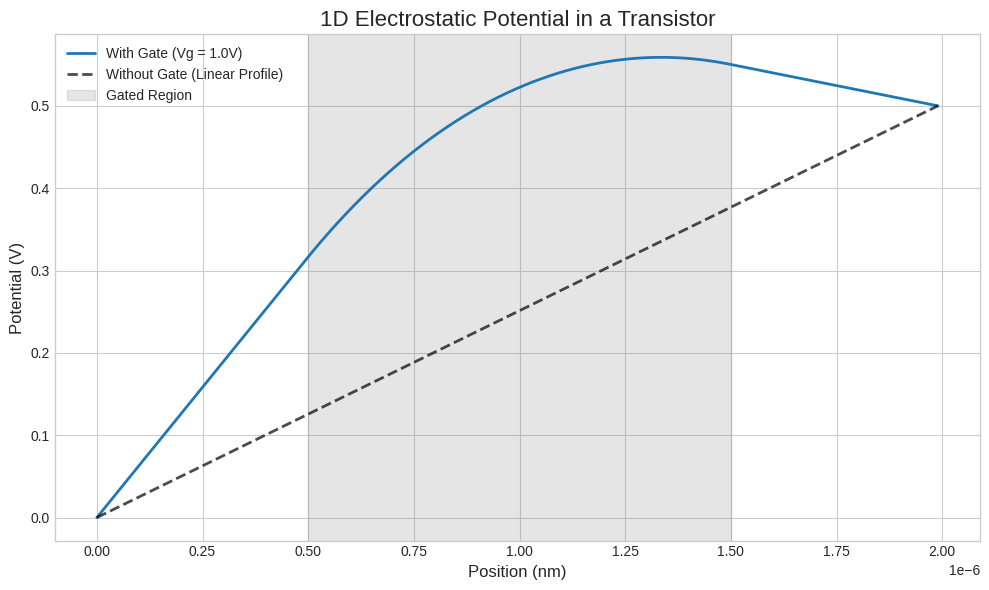

In [4]:
import numpy as np

# This is a placeholder for your Hamiltonian class.
# It's used to provide the physical parameters of the device.
class Hamiltonian:
    """
    A mock Hamiltonian class to store device parameters for demonstration.
    In your actual implementation, you would use your own Hamiltonian class.
    """
    def __init__(self, N=100, Vs=0.0, Vd=0.5, Vg=1.0, gate_factor=0.4, C_ox=0.1, dx=0.1):
        self.N = N                  # Number of grid points
        self.dx = dx                # Grid spacing (e.g., in nm)
        self.Vs = Vs                # Source voltage (Dirichlet BC)
        self.Vd = Vd                # Drain voltage (Dirichlet BC)
        self.gate = Vg              # Gate voltage
        self.gate_factor = gate_factor # Fraction of the device length covered by the gate
        self.C_ox = C_ox            # Oxide capacitance (units should be consistent with epsilon and dx)

def solve_laplace_initial_one_d(epsilon, ham: Hamiltonian):

    N = ham.N
    dx = ham.dx

    # --- Input Validation ---
    if not isinstance(epsilon, np.ndarray) or epsilon.shape != (N,):
        raise ValueError(f"epsilon must be a NumPy array of shape ({N},).")

    # --- Matrix and Vector Initialization ---
    # We will solve the linear system A*V = b
    A = np.zeros((N, N))
    b = np.zeros(N)

    # --- Boundary Conditions ---
    # 1. Dirichlet boundary condition at the source (left side, i=0)
    A[0, 0] = 1.0
    b[0] = ham.Vs

    # 2. Dirichlet boundary condition at the drain (right side, i=N-1)
    A[N-1, N-1] = 1.0
    b[N-1] = ham.Vd

    for i in range(1, N - 1):
        eps_minus = (epsilon[i - 1] + epsilon[i]) / 2.0
        eps_plus = (epsilon[i] + epsilon[i + 1]) / 2.0

        A[i, i - 1] = eps_minus
        A[i, i]     = -(eps_plus + eps_minus)
        A[i, i + 1] = eps_plus
    if ham.gate_factor > 0 and ham.C_ox > 0:
        gate_width_pts = int(ham.gate_factor * N)
        if gate_width_pts > 0:
            start_gate = (N - gate_width_pts) // 2
            end_gate = start_gate + gate_width_pts

            for i in range(start_gate, end_gate):
                if 1 <= i < N - 1:
                    A[i, i] -= dx * ham.C_ox
                    b[i] -= dx * ham.C_ox * ham.gate
    try:
        V = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        print("Warning: The matrix A is singular. This can happen if, for example,")
        print("all epsilon values are zero. Returning a linear potential as a fallback.")
        V = np.linspace(ham.Vs, ham.Vd, N)

    return V

# --- Example Usage ---
if __name__ == '__main__':
    import matplotlib.pyplot as plt

    # 1. Define the device parameters using the Hamiltonian class
    device_params = Hamiltonian(
        N=200,          # 200 grid points
        Vs=0.0,         # 0V at the source
        Vd=0.5,         # 0.5V at the drain
        Vg=1.0,         # 1.0V on the gate
        gate_factor=0.5,# Gate covers 50% of the device
        C_ox=0.15e-5,      # Capacitance value
        dx=1e-8          # 0.1 nm grid spacing
    )

    # 2. Define the dielectric constant profile
    # Let's assume a uniform dielectric constant for simplicity
    epsilon_profile = np.full(device_params.N, 8.854e-12 * 11.7) # Epsilon for Silicon

    # 3. Solve for the potential
    potential_solution = solve_laplace_initial_one_d(epsilon_profile, device_params)

    # 4. Plot the results
    x_axis = np.arange(device_params.N) * device_params.dx
    
    # Create a potential profile without a gate for comparison
    no_gate_params = Hamiltonian(Vg=0.0, C_ox=0.0, N=device_params.N, Vs=device_params.Vs, Vd=device_params.Vd)
    linear_potential = solve_laplace_initial_one_d(epsilon_profile, no_gate_params)


    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(x_axis, potential_solution, lw=2, label=f'With Gate (Vg = {device_params.gate}V)')
    ax.plot(x_axis, linear_potential, 'k--', lw=2, alpha=0.7, label='Without Gate (Linear Profile)')

    # Indicate the gated region
    gate_width_nm = (device_params.gate_factor * device_params.N) * device_params.dx
    gate_start_nm = ((device_params.N - device_params.gate_factor * device_params.N) / 2) * device_params.dx
    ax.axvspan(gate_start_nm, gate_start_nm + gate_width_nm, color='gray', alpha=0.2, label='Gated Region')

    ax.set_title('1D Electrostatic Potential in a Transistor', fontsize=16)
    ax.set_xlabel('Position (nm)', fontsize=12)
    ax.set_ylabel('Potential (V)', fontsize=12)
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()


Starting non-linear Poisson solver...
Iteration 1: Update norm = 1.9716e+01
Iteration 2: Update norm = 5.1080e-13

Converged after 2 iterations.


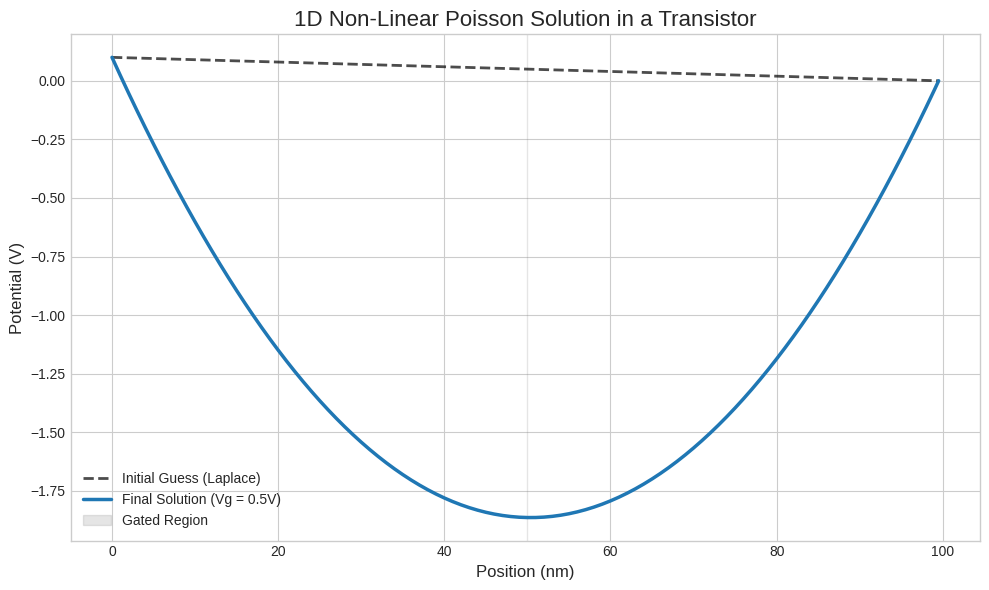

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

E_0 = 8.854e-12  
Q = 1.602e-19    
K_B = 1.380649e-23 
T = 300        
VT = K_B * T / Q 


class Hamiltonian:
    def __init__(self, N=100, Vs=0.0, Vd=0.5, Vg=1.0, gate_factor=0.4, C_ox=1e-6, dx=1e-9):
        self.N = N
        self.dx = dx
        self.Vs = Vs
        self.Vd = Vd
        self.gate = Vg
        self.gate_factor = gate_factor
        self.C_ox = C_ox 

def solve_laplace_initial_one_d(epsilon, ham: Hamiltonian):
    """initial solution without the non linear term """
    N = ham.N
    dx = ham.dx

    A = np.zeros((N, N))
    b = np.zeros(N)

    # BC
    A[0, 0] = 1.0
    b[0] = ham.Vs
    A[N-1, N-1] = 1.0
    b[N-1] = ham.Vd

    # mat
    for i in range(1, N - 1):
        eps_minus = (epsilon[i - 1] + epsilon[i]) / 2.0
        eps_plus = (epsilon[i] + epsilon[i + 1]) / 2.0
        A[i, i - 1] = eps_minus
        A[i, i]     = -(eps_plus + eps_minus)
        A[i, i + 1] = eps_plus
    
    # gate
    if ham.gate_factor > 0 and ham.C_ox > 0:
        gate_width_pts = int(ham.gate_factor * N)
        if gate_width_pts > 0:
            start_gate = (N - gate_width_pts) // 2
            end_gate = start_gate + gate_width_pts
            for i in range(start_gate, end_gate):
                if 1 <= i < N - 1:
                    A[i, i] -= dx * ham.C_ox
                    b[i] -= dx * ham.C_ox * ham.gate
    try:
        V = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        print("Singular matrix")
        V = np.linspace(ham.Vs, ham.Vd, N)
    return V

def solve_poisson_delta_one_d(V, diff_rho, rho, epsilon, doping, ham: Hamiltonian):
    N = ham.N
    dx = ham.dx
    
    A = np.zeros((N, N))
    b = np.zeros(N)

    # BC
    A[0, 0] = 1.0
    b[0] = 0
    A[N-1, N-1] = 1.0
    b[N-1] = 0

    # build jacobina
    for i in range(1, N - 1):
        eps_minus = (epsilon[i - 1] + epsilon[i]) / 2.0
        eps_plus = (epsilon[i] + epsilon[i + 1]) / 2.0

        A[i, i - 1] = eps_minus
        A[i, i]     = -(eps_plus + eps_minus) + diff_rho[i]
        A[i, i + 1] = eps_plus
        
        laplace_term = eps_plus * (V[i+1] - V[i]) - eps_minus * (V[i] - V[i-1])
        charge_term = dx**2 * (rho[i] - doping[i])
        
        residual = laplace_term  + charge_term
        b[i] = -residual

    # gate region 
    if ham.gate_factor > 0 and ham.C_ox > 0:
        gate_width_pts = int(ham.gate_factor * N)
        if gate_width_pts > 0:
            start_gate = (N - gate_width_pts) // 2
            end_gate = start_gate + gate_width_pts
            for i in range(start_gate, end_gate):
                if 1 <= i < N - 1:
                    A[i, i] -= dx * ham.C_ox
                    gate_residual = -dx * ham.C_ox * (V[i] - ham.gate)
                    b[i] -= gate_residual
    
    try:
        delta_V = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        print("Warning: The matrix A is singular. Returning a zero update.")
        delta_V = np.zeros_like(V)

    return delta_V

def solve_poisson_nonlinear(ham: Hamiltonian, doping_profile: np.ndarray, epsilon_profile: np.ndarray):
    """
    Iteratively solves the non-linear Poisson equation using newtons method 
    """

    V = solve_laplace_initial_one_d(epsilon_profile, ham)
    
    print("Starting non-linear Poisson solver...")
    for iteration in range(1000): 
        n_i = 1e24 
        charge_density = -Q * n_i * np.exp(V / VT )
        
        diff_charge_density_unscaled = charge_density / VT 
        diff_charge_density_scaled = ham.dx**2 * diff_charge_density_unscaled
        delta_V = solve_poisson_delta_one_d(
            V, diff_charge_density_scaled, charge_density, epsilon_profile, doping_profile, ham
        )
        V = V + delta_V

        update_norm = np.linalg.norm(delta_V)
        print(f"Iteration {iteration+1}: Update norm = {update_norm:.4e}")
        if update_norm < 1e-6:
            print(f"\nConverged after {iteration+1} iterations.")
            break
    else:
        print("\nWarning: Solver did not converge within the iteration limit.")
        
    return V, charge_density

device_params = Hamiltonian(
    N=200, Vs=0.1, Vd=0.0, Vg=0.5,
    gate_factor=0.0, C_ox=2e-5, dx=0.5e-9
)
epsilon_profile = np.full(device_params.N, 11.7 * E_0)
doping_profile = np.full(device_params.N, Q * 1e21) 
final_potential, charge_density = solve_poisson_nonlinear(device_params, doping_profile*0, epsilon_profile)

x_axis = np.arange(device_params.N) * device_params.dx * 1e9 
V_initial = solve_laplace_initial_one_d(epsilon_profile, device_params)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_axis, V_initial, 'k--', lw=2, alpha=0.7, label='Initial Guess (Laplace)')
ax.plot(x_axis, final_potential, lw=2.5, label=f'Final Solution (Vg = {device_params.gate}V)')
gate_width_nm = (device_params.gate_factor * device_params.N) * device_params.dx * 1e9
gate_start_nm = ((device_params.N - device_params.gate_factor * device_params.N) / 2) * device_params.dx * 1e9
ax.axvspan(gate_start_nm, gate_start_nm + gate_width_nm, color='gray', alpha=0.2, label='Gated Region')
ax.set_title('1D Non-Linear Poisson Solution in a Transistor', fontsize=16)
ax.set_xlabel('Position (nm)', fontsize=12)
ax.set_ylabel('Potential (V)', fontsize=12)
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


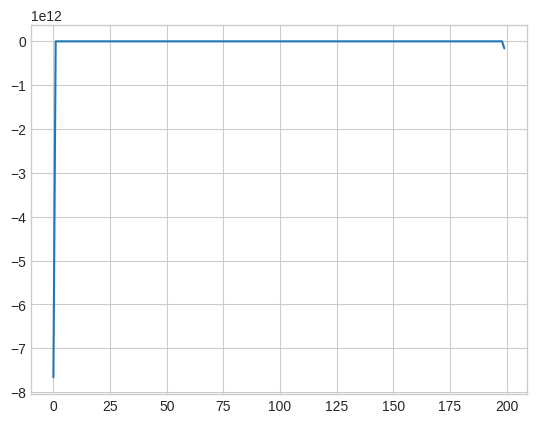

In [15]:
charge_density
plt.plot(charge_density)

In [ ]:
# 1. Quasi-Fermi level from solve_quasi_fermi_levels
Ec_guess = -2.0  # conduction band edge reference
V_profile = np.zeros(ham.N)
efn_solver = gf.solve_quasi_fermi_levels(V_profile, Ec=Ec_guess, precompute=True, verbose=False)
print('Solver Efn stats: min {:.4f} max {:.4f} mean {:.4f}'.format(efn_solver.min(), efn_solver.max(), efn_solver.mean()))

In [ ]:
# 2. Brute-force quasi-Fermi via scanning chemical potential to match n_target
# Use n_target from previously computed n (assumed electrons per site)
n_target = n.copy()
mu_scan = np.linspace(0, 1, 25)  # coarse grid
bf_efn = np.zeros_like(n_target)
for i in range(ham.N):
    # Simple monotonic search using precomputed LDOS at site i
    densities = []
    for mu in mu_scan:
        # reuse existing solver site_density logic via small wrapper
        # simulate by calling get_n with uniform Efn and extracting site i (expensive but illustrative)
        dens_i = gf.get_n(V=np.zeros(ham.N), Efn=np.full(ham.N, mu), Ec=-2, use_rgf=True, method='gauss_fermi')[i]
        densities.append(dens_i)
    densities = np.array(densities)
    # Find closest
    idx = np.argmin(np.abs(densities - n_target[i]))
    bf_efn[i] = mu_scan[idx]
print('Brute force Efn stats: min {:.4f} max {:.4f} mean {:.4f}'.format(bf_efn.min(), bf_efn.max(), bf_efn.mean()))

In [ ]:
# 3. Comparison & metrics
abs_err = np.abs(efn_solver - bf_efn)
rel_err = abs_err / (np.maximum(1e-12, np.abs(bf_efn)))
print('Mean abs err {:.3e}, max abs err {:.3e}'.format(abs_err.mean(), abs_err.max()))
print('Mean rel err {:.3e}, max rel err {:.3e}'.format(rel_err.mean(), rel_err.max()))
# Optional quick plot (if matplotlib available)
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,3))
    plt.plot(efn_solver, label='Solver')
    plt.plot(bf_efn, '--', label='Brute force')
    plt.xlabel('Site index'); plt.ylabel('Efn (eV)'); plt.legend(); plt.tight_layout()
    plt.figure(figsize=(6,2))
    plt.plot(abs_err, label='abs err')
    plt.xlabel('Site'); plt.ylabel('|ΔEfn| (eV)'); plt.tight_layout()
except Exception as e:
    print('Plot skipped:', e)